<a href="https://colab.research.google.com/github/drojassa/Undergrad_Thesis/blob/main/Transmitancia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Transmitancia de películas delgadas**


### Cálculo de los parámetros ópticos

Antes de todo se deben importar las librerias que se van a utilizar en el código

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os; from os import path
from scipy.interpolate import interp1d
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from scipy.optimize import curve_fit,fsolve, brentq
from sympy import symbols, Eq, solve
%matplotlib inline
PI=np.pi
fdat= open("GAPyParametros.txt","w+")
fdat.write("#Muestra  E0  Ed  d1  p1  p2  GAP")
fdat.close()

El procedimiento para obtener la simulación de los espectros es el siguiente

Se declaran los valores para el medio incidente (n0, k0), el sustrato (n2, k2). En este caso el sustrato era de vidrio y el medio incidente es aire por lo que n0=1, k0=0, n2=1.52 y k2=0

In [ ]:
n0 = 1; k0 = 0; k2 = 0; n2 = 1.52;

### Ingreso de datos

Ahora importamos los datos de todas las muestras como una tabla csv (ya recortada anteriormente) y se grafican

Nota: La primera fila del archivo debe ser el nombre de cada columna

In [ ]:
#-----(Aquí va la ruta del archivo) ⇲
datos_experimentales=pd.read_csv("Transmitancia.csv", sep=',', index_col=False)
datos_experimentales.columns = datos_experimentales.iloc[0];datos_experimentales = datos_experimentales[1:]
datos_experimentales=datos_experimentales.astype(float)

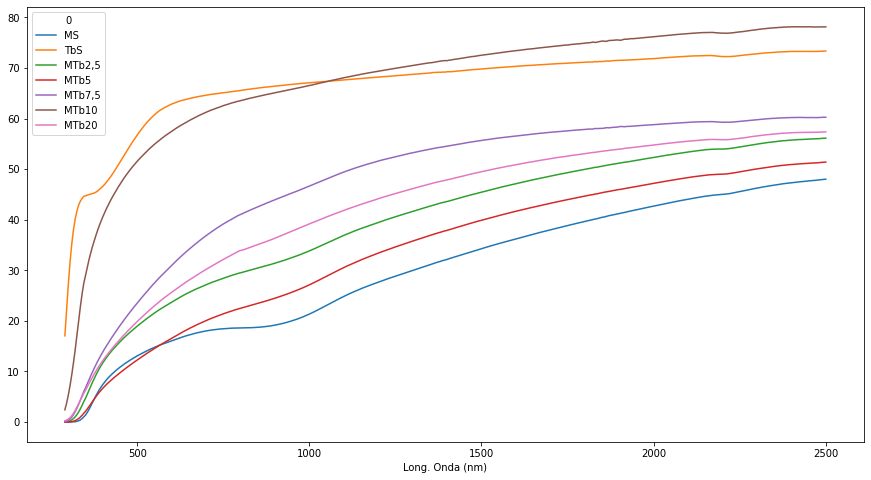

In [ ]:
#(OPCIONAL) EJECUTE ESTE CÓDIGO PARA GRAFICAR LOS DATOS
datos_experimentales.plot(x=datos_experimentales.columns.values[0], y=datos_experimentales.columns.values[1:], kind= "line", figsize=(15, 8))

Tambien importamos los datos de referencia que se van a usar para la interpolación de k en el modelo matemático

In [ ]:
#-(Ruta del archivo) ⇲
ck=pd.read_csv("ck1MS20.dat", sep='\t',names=['Long Onda', 'k'], index_col=False); ck=ck.astype(float)

En el siguiente código va el nombre de la columna que va a estudiar

In [ ]:
MUESTRA = 'MTb5'

In [ ]:
#En caso de tener problemas con el programa puede utilizar estos datos que se ajustan bien para comparar (DATOS ANTIGUOS)
datos_old=pd.read_csv('TexpMS20.dat',sep='\t',names=['Long Onda', 'T datos'], index_col=False)
datos_old=datos_old.astype(float)

Declararemos valores importantes como
numero de datos "ndat"
longitudes de onda "ldat"
transmitancia "tdat"
Así como una longitud de onda inicial y final (li, lf)

In [ ]:
ldat0= datos_experimentales[datos_experimentales.columns.values[0]].to_numpy()
tdat0= datos_experimentales[MUESTRA].to_numpy()/100; datosold=False
#tdat0= datos_old['T datos'].to_numpy()/100; datosold=True #Descomente esta línea si quiere utilizar los DATOS ANTIGUOS
ldat=ldat0 ;tdat=tdat0 ;ndat= len(ldat); li = ldat[0] ;lf = ldat[ndat-1]

Con los datos ingresados se genera una función de interpolación para k, esta es necesario dado que de lo contrario seria necesario escribir a mano un valor para cada una de las k, se grafican tanto los datos como la función de interpolación para comprobar la concordancia. Es importante rechazar los valores de k si se presentan ondulaciones y corregirlos desde Origin, la idea de eso es que las ondulaciones de la curva de transmitancias no se asocien con la absorción sino mas bien con la interferencia.

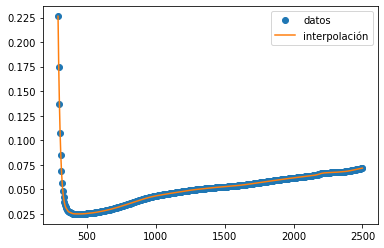

In [ ]:
k1 = interp1d(ck['Long Onda'].to_numpy(), ck['k'].to_numpy())
plt.plot(ldat, ck['k'].to_numpy(), 'o',label="datos");plt.plot(ldat, k1(ldat), '-',label="interpolación");
plt.legend(loc="upper right");plt.show()

## Modelo matemático

Las ecuaciones usada para simular los espectros son tomadas del modelo matricial y para trabajar la el indice de refracción se emplea el oscilador de WD. El conjunto de ecuaciones es el siguiente

In [ ]:
def n1(E0, Ed, l):
  value0 = (1+(E0*Ed)/(E0**2-(1240.8/l)**2))**(0.5)
  return value0

def g1(E0, Ed, l):
  value0 = (n0**2-n1(E0, Ed, l)**2-k1(l)**2)/((n0+n1(E0, Ed, l))**2+k1(l)**2)
  return value0

def h1(E0, Ed, l):
  value0 = (2*n1(E0, Ed, l)*k1(l))/((n0+n1(E0, Ed, l))**2+k1(l)**2)
  return value0

def g2(E0, Ed, l):
  value0 = (n1(E0, Ed, l)**2-n2**2+k1(l)**2-k2**2)/((n1(E0, Ed, l)+n2)**2+(k1(l)+k2)**2)
  return value0

def h2(E0, Ed, l):
  value0 = (2*(n1(E0, Ed, l)*k2-n2*k1(l)))/((n1(E0, Ed, l)+n2)**2+(k1(l)+k2)**2)
  return value0

def alpha0(d1, l):
  value0= 2*PI*k1(l)*d1/l
  return value0

def gamma0(E0, Ed, d1 , l):
  value0 = 2*PI*n1(E0, Ed, l)*d1/l
  return value0

def c(E0, Ed, l):
  value0 = 2*(g1(E0, Ed, l)*g2(E0, Ed, l)-h1(E0, Ed, l)*h2(E0, Ed, l))
  return value0

def d(E0, Ed, l):
  value0 = 2*(g1(E0, Ed, l)*h2(E0, Ed, l)+h1(E0, Ed, l)*g2(E0, Ed, l))
  return value0

def T1(l,E0, Ed, d1 ):
  value0 = (n2/n0)*(((1+g1(E0, Ed, l))**2+h1(E0, Ed, l)**2)*((1+g2(E0, Ed, l))**2+h2(E0, Ed, l)**2))/(np.exp(2*alpha0(d1, l))+(g1(E0, Ed, l)**2+h1(E0, Ed, l)**2)*(g2(E0, Ed, l)**2+h2(E0, Ed, l)**2)*np.exp((-2)*alpha0(d1,l))+c(E0, Ed, l)*np.cos(2*gamma0(E0, Ed, d1 , l))+d(E0, Ed, l)*np.sin(2*gamma0(E0, Ed, d1 , l)))
  return value0

## Determinación de los valores de las energías y el espesor

En esta etapa se calculan los valores de Ed, E0 y d1. Para el espesor d1 es buena practica usar valores cercanos a los obtenidos por el perfilómetro, pero no es camisa de fuerza.
Para determinar estos valores, se mueve el respectivo cursor en hasta que los datos experimentales (naranja) estén ajustados por la curva teórica en azul, para las películas con interferencia es muy importante que los máximos y mínimos coincidan entre los dos conjuntos de datos.


In [ ]:
def plot_T1(E0, Ed, d1):
    x = np.linspace(li ,lf, num=500); y = T1(x, E0, Ed, d1 )
    plt.figure(figsize=(12,8))
    plt.plot(x, y,label='primer ajuste teórico');plt.plot(ldat,tdat, '--',label='datos experimentales');plt.legend(loc="upper right")
    plt.ylim(-0.1,1.1)
interact(plot_T1, E0 = widgets.FloatSlider(value=13,min=1,max=50,step=0.1),Ed= widgets.FloatSlider(value=13,min=1,max=50,step=0.25), d1= widgets.FloatSlider(value=7.5,min=100,max=5000.0,step=1.0))

interactive(children=(FloatSlider(value=13.0, description='E0', max=50.0, min=1.0), FloatSlider(value=13.0, de…

<function __main__.plot_T1(E0, Ed, d1)>

Con los valores  obtenidos en la gráfica usted puede hacer una búsqueda mas refinada usando métodos numéricos para ello cambie los limites de E0, Ed y d1 en el siguiente comando.\
Estos resultados no siempre se ajustan bien debido a la norma empleada.

In [ ]:
E0inf = 1. ; E0sup=30. ;
Edinf = 1. ; Edsup=30. ;
d1inf = 200. ; d1sup=5000. ;
popt1, pcov = curve_fit(T1, ldat, tdat,bounds=([E0inf,Edinf,d1inf],[E0sup,Edsup,d1sup]))
print(" E0 =",popt1[0],"\n","Ed =",popt1[1],"\n","d1 =",popt1[2])

 E0 = 4.278621450471436 
 Ed = 3.6123049257733744 
 d1 = 2175.71751725464


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in sqrt
  


## Optimizar los valores de k

Una vez que se tienen valores adecuados de los parámetros anteriores, se calculan los valores que debe tener k para que el error entre los datos experimentales y teóricos sea menor que una tolerancia determinada por el usuario.
El conjunto de ecuaciones es planteado nuevamente para agregar el carácter de variable de k.

In [ ]:
def g1k(E0, Ed,l, knew):
  value0 = (n0**2-n1(E0, Ed, l)**2-knew**2)/((n0+n1(E0, Ed, l))**2+knew**2)
  return value0

def h1k(E0, Ed, l,  knew):
  value0 = (2*n1(E0, Ed, l)*knew)/((n0+n1(E0, Ed, l))**2+knew**2)
  return value0

def g2k(E0, Ed, l,knew):
  value0 = (n1(E0, Ed, l)**2-n2**2+knew**2-k2**2)/((n1(E0, Ed, l)+n2)**2+(knew+k2)**2)
  return value0

def h2k(E0, Ed, l, knew):
  value0 = (2*(n1(E0, Ed, l)*k2-n2*knew))/((n1(E0, Ed, l)+n2)**2+(knew+k2)**2)
  return value0

def alpha0k(d1, l,knew):
  value0= 2*PI*knew*d1/l
  return value0

def gamma0k(E0, Ed, d1 , l):
  value0 = 2*PI*n1(E0, Ed, l)*d1/l
  return value0

def ckk(E0, Ed, l,knew):
  value0 = 2*(g1k(E0, Ed, l,knew)*g2k(E0, Ed, l,knew)-h1k(E0, Ed, l,knew)*h2k(E0, Ed, l,knew))
  return value0

def dk(E0, Ed, l,knew):
  value0 = 2*(g1k(E0, Ed, l,knew)*h2k(E0, Ed, l,knew)+h1k(E0, Ed, l, knew)*g2k(E0, Ed, l,knew))
  return value0

def T1k(l,E0, Ed, d1,knew ):
  value0 = (n2/n0)*(((1+g1k(E0, Ed, l,knew))**2+h1k(E0, Ed, l,knew)**2)*((1+g2k(E0, Ed, l,knew))**2+h2k(E0, Ed, l,knew)**2))/(np.exp(2*alpha0k(d1, l,knew))+(g1k(E0, Ed, l,knew)**2+h1k(E0, Ed, l,knew)**2)*(g2k(E0, Ed, l,knew)**2+h2k(E0, Ed, l,knew)**2)*np.exp((-2)*alpha0k(d1,l,knew))+ckk(E0, Ed, l,knew)*np.cos(2*gamma0k(E0, Ed, d1 , l))+d(E0, Ed, l)*np.sin(2*gamma0k(E0, Ed, d1 , l)))
  return value0

El usuario define la tolerancia con la que se trabajará.

In [ ]:
Tol = 0.001;

Se toman los valores de E0, Ed y d1 hallados anteriormente para calcular los valores mas apropiados para k, para ello escriba los valores seleccionados.

In [ ]:
ValorE0 = 4.28
ValorEd = 3.6
Valord1 = 2175

En esta parte se realiza el ajuste y se gráfica los puntos hallados para la función k y una función de interpolación, una buena señal es que la gráfica no presente ondulaciones significativas.
En este paso se genera una función de interpolación para los valores finales de la función k (k1).

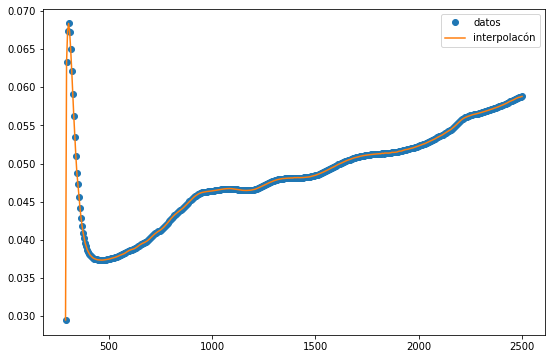

In [ ]:
def Tknew(k,i):
 return T1k(ldat[i],ValorE0, ValorEd, Valord1,k ) - tdat[i] - Tol
kvector1= []
for i in range(len(ldat)):
   kvector1.append(fsolve(Tknew,0.02, args=(i))[0])
kvector1=np.array(kvector1)
k1 = interp1d(ldat, kvector1)
plt.figure(figsize=(9,6));plt.plot(ldat, kvector1,'o',label='datos');plt.plot(ldat, k1(ldat),'-',label='interpolacón');
plt.legend(loc="upper right");plt.show()

RECORTE DE DATOS

In [ ]:
#EJECUTE ESTE COMANDO SOLAMENTE SI LA GRÁFICA EVIDENCIA PROBLEMAS CON LOS PRIMEROS N DATOS
#(cambie N manualmente y ejecute nuevamente el comando de arriba)
N=0;
ldat = ldat0;tdat= tdat0;ldat=ldat[N:];tdat=tdat[N:];ndat= len(ldat)
li = ldat[0] ;lf = ldat[ndat-1]

### Visualizar los resultados de k

A continuación se emplean los valores de k determinados para verificar la concordancia, si el ajuste fue bueno, las curvas coinciden casi que perfectamente.

In [ ]:
def plot_T1(E0, Ed, d1):
    x = np.linspace(li ,lf, num=500);y = T1(x, E0, Ed, d1 )
    plt.figure(figsize=(12,8))
    plt.plot(x, y,label='segundo ajuste teórico');plt.plot(ldat,tdat, '--',label='datos experimentales');plt.legend(loc="upper right")
    plt.ylim(-0.1,1.1)
interact(plot_T1, E0 = widgets.FloatSlider(value=7.5,min=0.001,max=30.0,step=0.1),Ed= widgets.FloatSlider(value=7.5,min=0.1,max=40.0,step=0.25), d1= widgets.FloatSlider(value=7.5,min=100,max=5000.0,step=1.0))

interactive(children=(FloatSlider(value=7.5, description='E0', max=30.0, min=0.001), FloatSlider(value=7.5, de…

<function __main__.plot_T1(E0, Ed, d1)>

Es necesario confirmar los valores finales de los parámetros E0, Ed y d1 para ser usados un los subsiguientes cálculos

In [ ]:
E0 = 4.28
Ed = 3.6
d1 = 2175

# Resultados

### Indice de refracción y absorción

Se definen los datos de indice de refracción y absorción. El primero se obtiene al reemplazar E0 y Ed en la ecuación de WD, para la absorción se usan los valores de k previamente hallados.
Los datos de absorción se condensan en una función de interpolación.

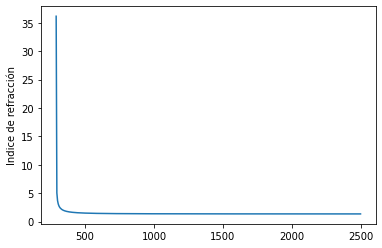

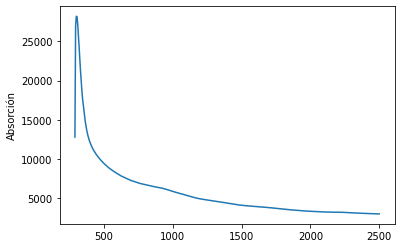

In [ ]:
lf1=ldat;k=np.array(kvector1)
abs0=10000000*4*PI*k/lf1
absorcion= interp1d(lf1, abs0)
plt.figure(1);plt.plot(ldat,n1(E0,Ed,ldat));plt.ylabel('Indice de refracción');
plt.figure(2);plt.plot(ldat,absorcion(ldat));plt.ylabel('Absorción');

### Cálculo del gap energético

Lo primero es graficar $(h\nu\alpha)^2$ contra la energía para decidir un intervalo de trabajo

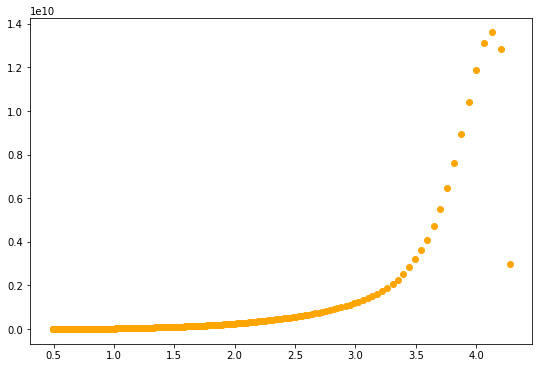

In [ ]:
xE=1240/lf1;yE=(1240*abs0/lf1)**2
plt.figure(figsize=(9,6));plt.plot(xE,yE,'o',color='orange')

Viendo los resultados se puede elegir un intervalo adecuado para determinar el Gap energético, en este caso por ejemplo un buen intervalo es entre 3.3 y 3.8, para ello se deben cambiar los valores manualmente

In [ ]:
Eni = 2.8;
Enf = 4.3;

Para manipular este gráfico tenga en cuenta dos cosas: 1) Los puntos se cuenta de derecha a izquierda, 2) para que la formula sea valida p1 debe estar siempre a la izquierda de p2, eso se logra haciendo p1 > p2.
La gráfica que se muestra en azul corresponde a una regresión lineal del rango de datos seleccionados. Para este ejemplo en particular, los mejores puntos son p1=14 y p2=6

In [ ]:
def plot_E(p2, p1):
    y=yE[p2-1:p1];x=xE[p2-1:p1]
    p = np.polyfit(x, y, 1);poly1d_fn=np.poly1d(p)
    fig, ax = plt.subplots(figsize=(12,8))
    plt.plot(xE, poly1d_fn(xE), '--b');
    plt.plot(xE,yE, 'o',color='orange')
    plt.xlim(Eni,Enf);plt.ylim(0.01,yE.max()*(1.1))
    for i in range(30):
        ax.annotate(i+1, (xE[i], yE[i]), ha="left",color ='grey' )
interact(plot_E, p2 = widgets.IntSlider(value=2,min=1,max=30,step=1),p1 = widgets.IntSlider(value=5,min=0,max=30,step=1))

interactive(children=(IntSlider(value=2, description='p2', max=30, min=1), IntSlider(value=5, description='p1'…

<function __main__.plot_E(p2, p1)>

Ingrese el valor de los puntos para los cuales encontró la mejor aproximación de una linea recta

In [ ]:
p2=5
p1=12

Ahora se resuelve la recta y se da el valor del Gap

In [ ]:
y=yE[p2-1:p1];x=xE[p2-1:p1];p = np.polyfit(x, y, 1);poly1d_fn=np.poly1d(p)
GAP = fsolve(poly1d_fn, 1)
dec = 3 #CIFRAS DECIMALES
print('El Gap de la pelicula es ',round(GAP[0],dec),' eV')


El Gap de la pelicula es  3.409  eV


### Exportar los resultados

Finalmente se exportan los datos para el espectro simulado, indice de refracción, absorción, los valores de k  y $\alpha^2$, se crea una carpeta para los datos. Si la carpeta no aparece inmediatamente espere 2 minutos

In [ ]:
datos_Tsimulada=pd.DataFrame({'Long. Onda (nm)' : ldat,'T simulada' : T1(ldat,E0,Ed,d1)}, columns=['Long. Onda (nm)','T simulada'])
datos_IndiceRefraccion=pd.DataFrame({'Long. Onda (nm)' : ldat,'Indice Refracción' : n1(E0,Ed,ldat)}, columns=['Long. Onda (nm)','Indice Refracción'])
datos_ksimulada=pd.DataFrame({'Long. Onda (nm)' : ldat,'k simulada' : k1(ldat)}, columns=['Long. Onda (nm)','k simulada'])
datos_absf=pd.DataFrame({'Long. Onda (nm)' : ldat,'Abs' : abs0}, columns=['Long. Onda (nm)','Abs'])
datos_alpha2=pd.DataFrame({'1240/lambda' : xE,'(1240*abs/lambda)^2' : yE}, columns=['1240/lambda','(1240*abs/lambda)^2'])
#----------------------------------------------------------------------------------------------------------------------------------------------------
Muestra0 = MUESTRA  if datosold == False else 'OLD_MS20';
os.mkdir(Muestra0) if path.exists(Muestra0)==False else print('Los archivos para '+Muestra0+' serán sobreescritos')
datos_Tsimulada.to_csv(Muestra0+'/'+'Tsimulada_'+Muestra0+'.dat',index=False,sep = ' ')
datos_IndiceRefraccion.to_csv(Muestra0+'/'+'IndiceRefraccion_'+Muestra0+'.dat',index=False,sep = ' ')
datos_ksimulada.to_csv(Muestra0+'/'+'ksimulada_'+Muestra0+'.dat',index=False,sep = ' ')
datos_absf.to_csv(Muestra0+'/'+'absf_'+Muestra0+'.dat',index=False,sep = ' ')
datos_alpha2.to_csv(Muestra0+'/'+'alpha2_'+Muestra0+'.dat',index=False,sep = ' ')

Estos datos están listos para ser graficados y presentados en Origin.

In [ ]:
with open("GAPyParametros.txt", "a+") as file_object:
    # Move read cursor to the start of file.
    file_object.seek(0)
    # If file is not empty then append '\n'
    data = file_object.read(100)
    if len(data) > 0 :
        file_object.write("\n")
    # Append text at the end of file
    file_object.write(str(Muestra0)+"  "+str(E0)+"  "+str(Ed)+"  "+str(d1)+"  "+str(p1)+"  "+str(p2)+"  "+str(GAP))